### **Mô hình Phân cụm (Clustering Model) – Phân loại khách hàng**

#### 1. Mục tiêu của mô hình
Mô hình phân cụm nhằm chia tập khách hàng thành các nhóm có hành vi tương đồng, từ đó giúp doanh nghiệp:
- Hiểu rõ đặc điểm từng nhóm khách hàng
- Thiết kế chiến dịch marketing cá nhân hoá
- Tăng hiệu quả chăm sóc, giữ chân khách hàng
- Dự đoán rủi ro rời bỏ và tối ưu chuyển đổi

---

#### 2. Phương pháp sử dụng: K-Means Clustering

**K-Means** là thuật toán phân cụm phổ biến nhất, hoạt động theo nguyên tắc:
1. Chọn số cụm K.
2. Gán mỗi điểm dữ liệu vào cụm gần nhất (dựa trên khoảng cách Euclidean).
3. Cập nhật tâm cụm → lặp lại đến khi hội tụ.

Thuật toán tìm cách **giảm tổng khoảng cách từ các điểm đến tâm cụm** – giúp các cụm nội bộ đồng nhất nhất có thể.

---

#### 3. Các đặc trưng được sử dụng trong phân cụm
Tính các đặc trưng để phân cụm:
- **RFM**:
  - Recency: Số ngày kể từ lần mua cuối.
  - Frequency: Số phiên mua duy nhất.
  - Monetary: Tổng chi tiêu.
- **Conversion Rate**: Tỷ lệ phiên mua trên phiên xem.
- **Cart Abandonment Rate**: Tỷ lệ giỏ hàng không dẫn đến mua.


## 1. Import thư viện 

In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib


## 2. Đọc dữ liệu

In [443]:
# Đọc file và chuyển đổi event_time sang datetime
df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])

# Hiển thị 5 dòng đầu tiên
df.head()

C:\Users\quoch\AppData\Local\Temp\ipykernel_7140\2360404760.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("events_processed.csv", parse_dates=['event_time'])


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,year,month,day,quarter,week,weekday,dayofyear,category,sub_category,sub_sub_category,sub_sub_sub_category
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,unknown,31.90,1515915625519388267,LJuJVLEjPT,2020,9,24,3,39,3,268,electronics,telephone,0,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,2020,9,24,3,39,3,268,computers,components,cooler,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,unknown,unknown,9.81,1515915625513238515,4TMArHtXQy,2020,9,24,3,39,3,268,unknown,0,0,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,2020,9,24,3,39,3,268,computers,peripherals,printer,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,unknown,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,2020,9,24,3,39,3,268,unknown,0,0,0


### 3. Tiền xử lí dữ liệu sẵn sàng cho K-means

In [444]:
# Phân bố loại sự kiện
event_counts = df['event_type'].value_counts()
print('\nPhân bố loại sự kiện:')
print(event_counts)
print('\nTỷ lệ phần trăm:')
print((event_counts / len(df) * 100).round(2))


Phân bố loại sự kiện:
event_type
view        793589
cart         54029
purchase     37346
Name: count, dtype: int64

Tỷ lệ phần trăm:
event_type
view        89.67
cart         6.11
purchase     4.22
Name: count, dtype: float64



Nhận xét:
Dữ liệu chứa các sự kiện xem (view), thêm giỏ (cart), và mua (purchase). Tỷ lệ view chiếm đa số, cho thấy nhiều người dùng chỉ xem mà không mua.

In [445]:
# Lọc các hành vi
df_purchase = df[df['event_type'] == 'purchase']
df_view = df[df['event_type'] == 'view']
df_cart = df[df['event_type'] == 'cart']

In [446]:
# Ngày tham chiếu (mốc cuối cùng)
reference_date = df['event_time'].max()

# Recency: Số ngày từ lần mua cuối
recency = (df_purchase.groupby('user_id')['event_time']
           .max()
           .apply(lambda x: (reference_date - x).days)
           .reset_index(name='Recency'))

In [447]:
# Frequency: Số phiên mua duy nhất
frequency = (df_purchase.drop_duplicates(subset=['user_id', 'user_session'])
             .groupby('user_id')
             .size()
             .reset_index(name='Frequency'))

In [448]:
# Monetary: Tổng chi tiêu
monetary = (df_purchase.groupby('user_id')['price']
            .sum()
            .reset_index(name='Monetary'))

In [449]:
# Conversion Rate: Số phiên mua / số phiên xem
view_sessions = (df_view.drop_duplicates(subset=['user_id', 'user_session'])
                 .groupby('user_id')
                 .size()
                 .reset_index(name='ViewSessions'))

In [450]:
purchase_sessions = (df_purchase.drop_duplicates(subset=['user_id', 'user_session'])
                     .groupby('user_id')
                     .size()
                     .reset_index(name='PurchaseSessions'))

In [451]:
conversion = pd.merge(view_sessions, purchase_sessions, on='user_id', how='left').fillna(0)


In [452]:
conversion['ConversionRate'] = conversion.apply(
    lambda x: x['PurchaseSessions'] / x['ViewSessions'] if x['ViewSessions'] > 0 else np.nan, axis=1
)

In [453]:
conversion = conversion[['user_id', 'ConversionRate']]

In [454]:
# Cart Abandonment Rate: (Giỏ - Mua) / Giỏ
cart_sessions = (df_cart.drop_duplicates(subset=['user_id', 'user_session'])
                 .groupby('user_id')
                 .size()
                 .reset_index(name='CartSessions'))

In [455]:
cart_abandon = pd.merge(cart_sessions, purchase_sessions, on='user_id', how='left').fillna(0)


In [456]:
cart_abandon['CartAbandonmentRate'] = cart_abandon.apply(
    lambda x: (x['CartSessions'] - x['PurchaseSessions']) / x['CartSessions'] if x['CartSessions'] > 0 else 0, axis=1
)


In [457]:
cart_abandon = cart_abandon[['user_id', 'CartAbandonmentRate']]

In [458]:
# Gộp đặc trưng
dfs = [recency, frequency, monetary, conversion, cart_abandon]
df_user_features = dfs[0]
for d in dfs[1:]:
    df_user_features = pd.merge(df_user_features, d, on='user_id', how='outer')

# Loại user thiếu RFM
df_user_features.dropna(subset=['Recency', 'Frequency', 'Monetary'], inplace=True)

# Điền giá trị thiếu bằng median
df_user_features['ConversionRate'].fillna(df_user_features['ConversionRate'].median(), inplace=True)
df_user_features['CartAbandonmentRate'].fillna(0, inplace=True)

df_user_features.head()

,user_id,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate
0,1515915625353286099,148.0,1.0,119.03,0.142857,0.5
1,1515915625353457259,152.0,1.0,55.16,1.000000,0.0
2,1515915625353534622,145.0,1.0,57.15,1.000000,0.0
3,1515915625353561691,95.0,1.0,345.72,0.500000,0.0
4,1515915625353900095,136.0,1.0,57.85,0.500000,0.5


In [459]:
df_user_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21304 entries, 0 to 21303
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              21304 non-null  int64  
 1   Recency              21304 non-null  float64
 2   Frequency            21304 non-null  float64
 3   Monetary             21304 non-null  float64
 4   ConversionRate       21304 non-null  float64
 5   CartAbandonmentRate  21304 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.1 MB


In [460]:
# Xử lý ngoại lệ bằng IQR
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

for col in ['Recency', 'Frequency', 'Monetary']:
    df_user_features = cap_outliers(df_user_features, col)


In [461]:
df_user_features.head()

,user_id,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate
0,1515915625353286099,148.0,1.0,119.03,0.142857,0.5
1,1515915625353457259,152.0,1.0,55.16,1.000000,0.0
2,1515915625353534622,145.0,1.0,57.15,1.000000,0.0
3,1515915625353561691,95.0,1.0,345.72,0.500000,0.0
4,1515915625353900095,136.0,1.0,57.85,0.500000,0.5


In [462]:
df_user_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21304 entries, 0 to 21303
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              21304 non-null  int64  
 1   Recency              21304 non-null  float64
 2   Frequency            21304 non-null  float64
 3   Monetary             21304 non-null  float64
 4   ConversionRate       21304 non-null  float64
 5   CartAbandonmentRate  21304 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 1.1 MB



Nhận xét:\
Các đặc trưng RFM, Conversion Rate, và Cart Abandonment Rate đã được tạo.\
Giá trị thiếu được xử lý bằng median, và ngoại lệ được giới hạn bằng IQR để tránh ảnh hưởng đến K-Means.

#### Chuẩn hóa các đặc trưng để đảm bảo trọng số đồng đều khi phân cụm.

In [463]:
# Chọn đặc trưng để phân cụm
features = ['Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate']
X = df_user_features[features].copy()

In [464]:
# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [465]:
# Hiển thị dữ liệu chuẩn hóa
df_scaled = pd.DataFrame(X_scaled, columns=features, index=df_user_features.index)
print('5 dòng đầu của dữ liệu chuẩn hóa:')
print(df_scaled.head())

5 dòng đầu của dữ liệu chuẩn hóa:
    Recency  Frequency  Monetary  ConversionRate  CartAbandonmentRate
0  1.651011        0.0 -0.338966       -1.984895             1.988702
1  1.739715        0.0 -0.645155        0.533328             0.066216
2  1.584483        0.0 -0.635615        0.533328             0.066216
3  0.475682        0.0  0.747776       -0.935635             0.066216
4  1.384899        0.0 -0.632260       -0.935635             1.988702



Nhận xét: \
Dữ liệu đã được chuẩn hóa để đảm bảo các đặc trưng có cùng thang đo, phù hợp với K-Means.

## 4. Chọn số cụm tối ưu

Dùng Elbow Method để xác định số cụm \( K \) phù hợp.

In [466]:
# Tính inertia cho các giá trị K
inertias = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

c:\Users\quoch\Downloads\ecommerce-analysis\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\quoch\Downloads\ecommerce-analysis\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\quoch\Downloads\ecommerce-analysis\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\quoch\Downloads\ecommerce-analysis\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416:

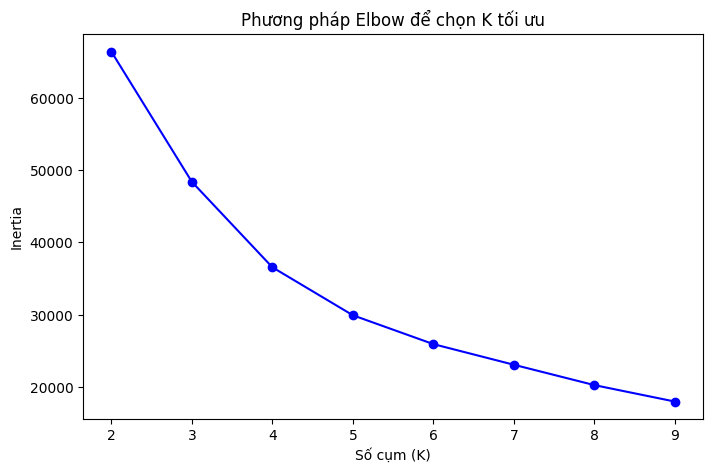

In [467]:
# Vẽ Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Số cụm (K)')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow để chọn K tối ưu')
plt.show()

### Nhận xét từ biểu đồ Elbow Method

Biểu đồ trên thể hiện mối quan hệ giữa **số cụm (K)** và **Inertia** – tổng bình phương khoảng cách từ các điểm đến tâm cụm.

- Khi tăng K từ 2 → 4, **Inertia giảm mạnh**, cho thấy mô hình phân cụm hiệu quả hơn rõ rệt.
- Từ **K = 4 đến K = 6**, độ dốc vẫn còn nhưng bắt đầu **chậm lại**.
- Từ **K ≥ 7**, đường cong **gần như phẳng** → tăng K không giúp giảm Inertia đáng kể nữa.

**Nhận xét***: \
Đường cong Elbow cho thấy điểm uốn tại K=4 hoặc K=5. \
Chọn K=4 để cân bằng giữa độ phức tạp và chất lượng phân cụm.

## 5. Phân cụm với K-Means

Áp dụng K-Means với \( K=4 \).

In [468]:
# Phân cụm
kmeans = KMeans(n_clusters=4, random_state=42)
df_user_features['cluster'] = kmeans.fit_predict(X_scaled)

c:\Users\quoch\Downloads\ecommerce-analysis\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Nhận xét:
Đã phân cụm khách hàng thành 4 nhóm. Kết quả được gán vào cột "cluster".

In [469]:
# Nhận xét
print('Nhận xét:')
print('Đã phân cụm khách hàng thành 4 nhóm. Kết quả được gán vào cột "cluster".')

Nhận xét:
Đã phân cụm khách hàng thành 4 nhóm. Kết quả được gán vào cột "cluster".


## 6. Trực quan hóa bằng PCA

In [470]:
# Giảm chiều bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_user_features['PCA1'] = X_pca[:, 0]
df_user_features['PCA2'] = X_pca[:, 1]

In [471]:
# Báo cáo phương sai
print('Tỷ lệ phương sai PCA:', pca.explained_variance_ratio_)
print('Tổng phương sai giải thích:', sum(pca.explained_variance_ratio_))

# Giảm chiều tâm cụm
centers_pca = pca.transform(kmeans.cluster_centers_)

Tỷ lệ phương sai PCA: [0.38040509 0.30646744]
Tổng phương sai giải thích: 0.6868725304950501


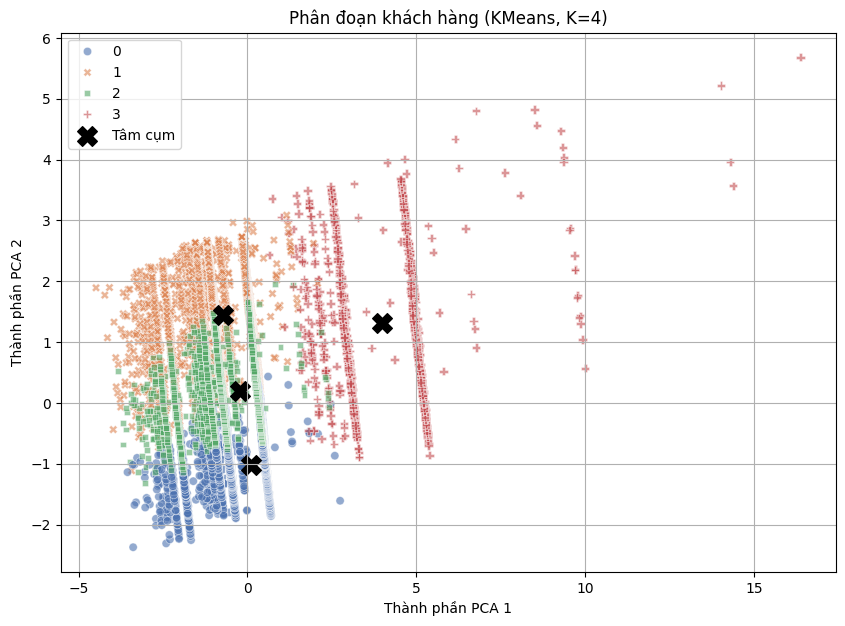

In [472]:
# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_user_features, x='PCA1', y='PCA2', hue='cluster', style='cluster', palette='deep', alpha=0.6)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, marker='X', label='Tâm cụm')
plt.title('Phân đoạn khách hàng (KMeans, K=4)')
plt.xlabel('Thành phần PCA 1')
plt.ylabel('Thành phần PCA 2')
plt.legend()
plt.grid(True)
plt.show()

Biểu đồ thể hiện phân bố khách hàng theo 4 cụm sau khi giảm chiều dữ liệu bằng PCA. Mỗi cụm được biểu diễn bằng màu sắc khác nhau với vị trí tâm cụm thể hiện bằng dấu "X".

Cụm 0: Phân bố thấp về cả hai thành phần PCA, cho thấy tần suất và giá trị đơn hàng thấp, khả năng quay lại mua hàng kém.

Cụm 1: Phân bố khá gần trung tâm, cho thấy họ mới phát sinh giao dịch, tiềm năng phát triển.

Cụm 2: Có xu hướng tập trung dày đặc, cho thấy nhóm này mua hàng đều đặn và giá trị đơn hàng cao.

Cụm 3: Phân bố lệch xa, cho thấy họ có hành vi truy cập và thêm hàng vào giỏ nhưng không hoàn tất giao dịch.

## 7. Phân tích và gán nhãn cụm

Tính trung bình đặc trưng mỗi cụm và gán nhãn dựa trên hành vi.

In [473]:
# Tính trung bình đặc trưng theo cụm
cluster_profile = (df_user_features.groupby('cluster')[features]
                  .mean()
                  .round(2)
                  .reset_index())

In [474]:
#Đếm số khách hàng mỗi cụm
cluster_counts = df_user_features['cluster'].value_counts().sort_index().reset_index()
cluster_counts.columns = ['cluster', 'num_customers']

In [475]:
# Tính tỷ lệ phần trăm
total_customers = cluster_counts['num_customers'].sum()
cluster_counts['percentage'] = (cluster_counts['num_customers'] / total_customers * 100).round(2)

In [476]:
# Gộp kết quả
cluster_profile = pd.merge(cluster_profile, cluster_counts, on='cluster')

In [477]:
print('thông tin cụm:')
cluster_profile

thông tin cụm:


,cluster,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate,num_customers,percentage
0,0,117.10,1.0,89.47,0.83,0.02,8499,39.89
1,1,51.86,1.0,543.93,0.69,0.06,4117,19.33
2,2,37.68,1.0,99.29,0.79,0.02,7748,36.37
3,3,70.48,1.0,290.50,1.47,-1.04,940,4.41


In [478]:
# Gán nhãn cụm
cluster_labels = {
    0: 'Khách ít mua',
    1: 'Khách mới mua',
    2: 'Khách thân thiết',
    3: 'Khách bỏ giỏ hàng'
}

In [479]:
cluster_comments = {
    0: 'Khách ít mua sắm gần đây, mua ít và chi tiêu thấp. Có thể gửi email ưu đãi để khuyến khích mua lại.',
    1: 'Khách mới bắt đầu mua, còn mua ít. Nên chăm sóc tốt để họ quay lại mua nhiều hơn.',
    2: 'Khách mua nhiều, chi tiêu cao, hay quay lại. Cần ưu tiên chăm sóc, tặng quà hoặc ưu đãi đặc biệt.',
    3: 'Khách hay thêm sản phẩm vào giỏ nhưng không mua. Cần ưu đãi khi thanh toán hoặc làm giỏ hàng dễ dùng hơn.'
}

In [480]:
cluster_profile['cluster_label'] = cluster_profile['cluster'].map(cluster_labels)
cluster_profile['comment'] = cluster_profile['cluster'].map(cluster_comments)

In [481]:
# Sắp xếp cột cho rõ ràng
cluster_profile = cluster_profile[['cluster', 'cluster_label', 'num_customers', 'percentage', 'Recency', 'Frequency', 'Monetary', 'ConversionRate', 'CartAbandonmentRate', 'comment']]

In [482]:
cluster_profile.head()

,cluster,cluster_label,num_customers,percentage,Recency,Frequency,Monetary,ConversionRate,CartAbandonmentRate,comment
0,0,Khách ít mua,8499,39.89,117.10,1.0,89.47,0.83,0.02,"Khách ít mua sắm gần đây, mua ít và chi tiêu t..."
1,1,Khách mới mua,4117,19.33,51.86,1.0,543.93,0.69,0.06,"Khách mới bắt đầu mua, còn mua ít. Nên chăm só..."
2,2,Khách thân thiết,7748,36.37,37.68,1.0,99.29,0.79,0.02,"Khách mua nhiều, chi tiêu cao, hay quay lại. C..."
3,3,Khách bỏ giỏ hàng,940,4.41,70.48,1.0,290.50,1.47,-1.04,Khách hay thêm sản phẩm vào giỏ nhưng không mu...



Nhận xét:
- Hồ sơ cụm cho thấy sự khác biệt rõ rệt: khách hàng trung thành có giá trị cao, Khách hàng chỉ xem ít tương tác, khách hay bỏ giỏ.


C:\Users\quoch\AppData\Local\Temp\ipykernel_7140\2562339891.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x='cluster_label', y='num_customers', palette='deep')


([0, 1, 2, 3],
 [Text(0, 0, 'Khách ít mua'),
  Text(1, 0, 'Khách mới mua'),
  Text(2, 0, 'Khách thân thiết'),
  Text(3, 0, 'Khách bỏ giỏ hàng')])

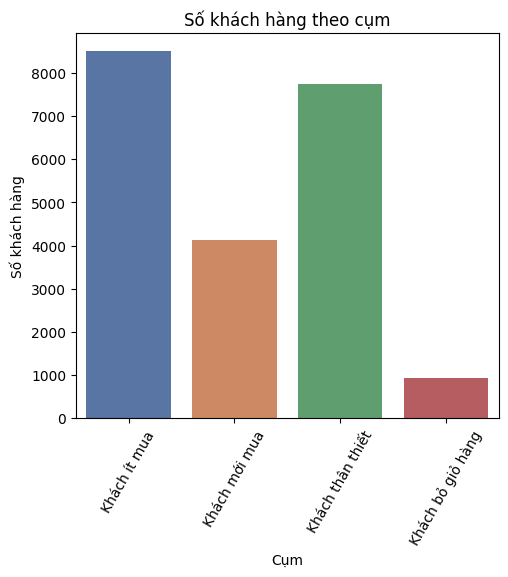

In [483]:
# Vẽ biểu đồ 1: Số khách hàng và tỷ lệ phần trăm theo cụm
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
sns.barplot(data=cluster_profile, x='cluster_label', y='num_customers', palette='deep')
plt.title('Số khách hàng theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Số khách hàng')
plt.xticks(rotation=60)

**Nhận xét:**:

Khách ít mua là nhóm đông nhất (~8500 khách).

Khách thân thiết đứng thứ hai (~7800 khách), là nhóm cần giữ chân.

Khách mới mua chiếm lượng khá (~4200 khách), có tiềm năng

Khách bỏ giỏ hàng là nhóm nhỏ nhất (~900 khách) khá thấp

C:\Users\quoch\AppData\Local\Temp\ipykernel_7140\3351642780.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_profile, x='cluster_label', y='percentage', palette='deep')


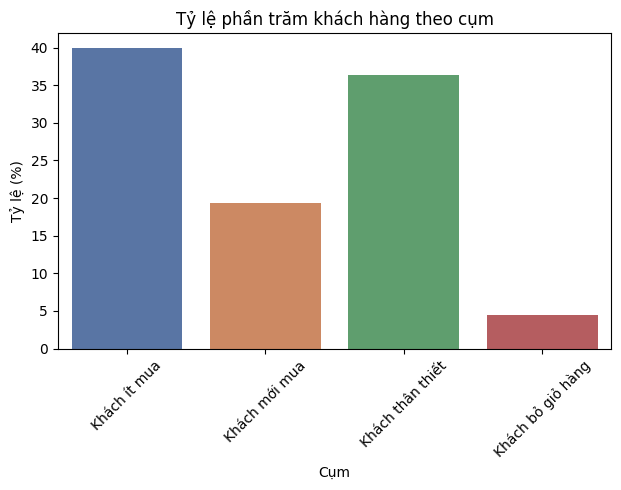

In [484]:
plt.figure(figsize=(12, 5))  

plt.subplot(1, 2, 2)
sns.barplot(data=cluster_profile, x='cluster_label', y='percentage', palette='deep')
plt.title('Tỷ lệ phần trăm khách hàng theo cụm')
plt.xlabel('Cụm')
plt.ylabel('Tỷ lệ (%)')
plt.xticks(rotation=45)  

plt.tight_layout()  
plt.show()

**Nhận xét:** \
Khách ít mua chiếm khoảng 40% tổng số khách hàng.

Khách thân thiết khoảng 36%, phản ánh sự ổn định trong tập khách hàng.

Khách mới mua chiếm gần 20%, là nhóm cần chăm sóc kỹ để tránh rơi vào nhóm khách rời bỏ.

Khách bỏ giỏ hàng chỉ khoảng 4%, nhưng là cơ hội lớn để cải thiện doanh số nếu có các chiến dịch tiếp thị lại hiệu quả.

In [485]:
# Vẽ biểu đồ 2: So sánh đặc trưng trung bình giữa các cụm
# Chuyển dữ liệu sang định dạng melt vẽ nhiều đặc trưng
cluster_profile_melt = pd.melt(
    cluster_profile,
    id_vars=['cluster', 'cluster_label'],
    value_vars=features,
    var_name='Feature',
    value_name='Value'
)

<Figure size 1200x600 with 0 Axes>

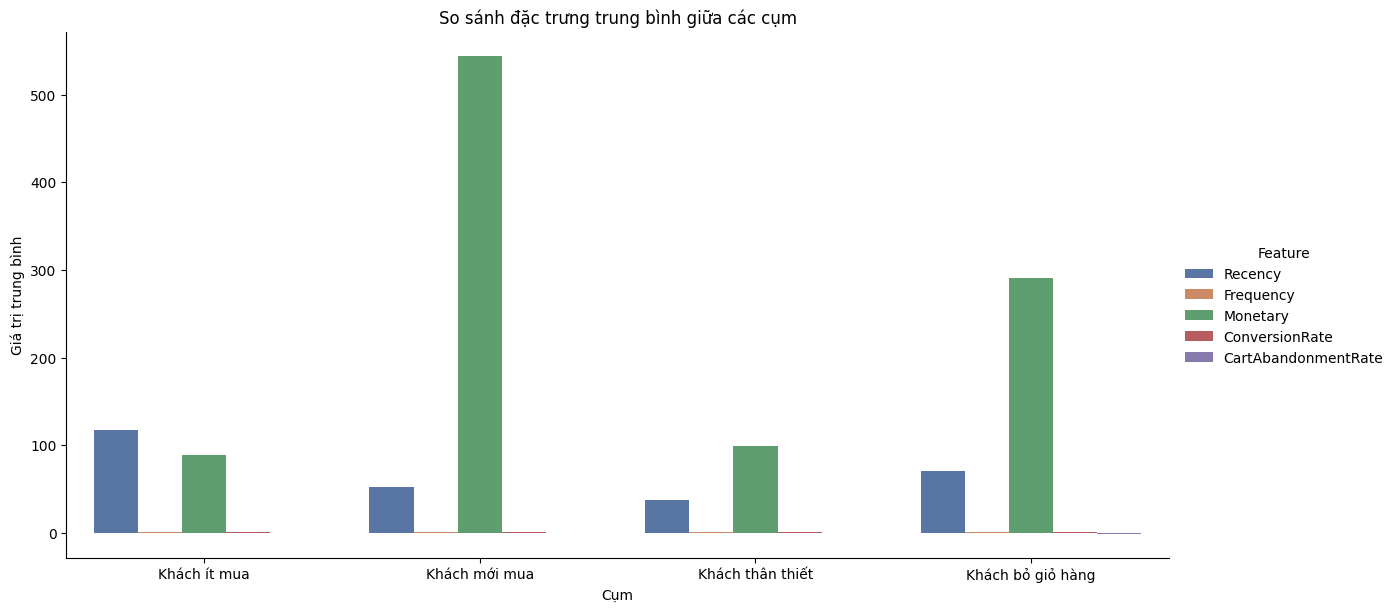

In [486]:
plt.figure(figsize=(12, 6))
sns.catplot(data=cluster_profile_melt, x='cluster_label', y='Value', hue='Feature', kind='bar', height=6, aspect=2, palette='deep')
plt.title('So sánh đặc trưng trung bình giữa các cụm')
plt.xlabel('Cụm')
plt.ylabel('Giá trị trung bình')
plt.xticks(rotation=0)
plt.show()

**Nhận xét:** \
Khách thân thiết có tần suất mua cao (Frequency) và giá trị đơn hàng lớn (Monetary), đồng thời thời gian mua gần đây (Recency) thấp, chứng tỏ họ vẫn đang hoạt động.

Khách mới mua có Monetary cao đột biến nhưng Frequency thấp – có thể là do họ mới thực hiện một giao dịch lớn.

Khách bỏ giỏ hàng có Cart Abandonment Rate cao, Conversion Rate rất thấp – phản ánh rõ hành vi từ bỏ giỏ.

Khách ít mua có tất cả các chỉ số ở mức trung bình hoặc thấp.